In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turbofan/df_train.csv
/kaggle/input/turbofan/df_test.csv


In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from itertools import chain
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.linear_model import LinearRegression as lr
#from sklearn.model_selection import TimeSeriesSplit as tsplit
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch.optim as optim
from torch.utils.data import Dataset
from collections import defaultdict

In [4]:
df_train = pd.read_csv('/kaggle/input/turbofan/df_train.csv')
df_test = pd.read_csv('/kaggle/input/turbofan/df_test.csv')

In [5]:
df_train.columns

Index(['unit_abs', 'unit_number', 'time_cycle', 'setting_1', 'setting_2',
       'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21', 'RUL'],
      dtype='object')

In [6]:
#Preparing new data with the columns that will be smoothed
df_train_for_smo = df_train[['unit_abs','sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21']]
df_test_for_smo = df_test[['unit_abs','sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17',
       'sensor20', 'sensor21']]

In [7]:
# Smoothing the data with Exponential Weighted Moving Average. It is already implemented in pandas library.
# We need to implement the smoothing over each unit in the dataset, otherwise it would get the noise between the end of the cycle
# of a unit and the beggining of the following unit.

alpha = .2
train_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_train_for_smo[df_train_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    train_smooth = train_smooth.append(smoothed_df)

In [8]:
# Smoothing the test data with Exponential Weighted Moving Average.
test_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_test_for_smo[df_test_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    test_smooth = test_smooth.append(smoothed_df)

In [9]:
# Separating the dataset for MinMaxScaler (remove the unit column) #
train_smooth_for_sc = train_smooth.iloc[:,1:]
test_smooth_for_sc = test_smooth.iloc[:,1:]

In [10]:
smooth_col = train_smooth_for_sc.columns

In [11]:
# Standardize the data because neural networks perform better with standardized data. 
scaler = MinMaxScaler()
df_train_sc_np = scaler.fit_transform(train_smooth_for_sc)
df_test_sc_np = scaler.fit_transform(test_smooth_for_sc)

In [12]:
df_train_sc = pd.DataFrame(df_train_sc_np,columns = smooth_col)
df_test_sc = pd.DataFrame(df_test_sc_np,columns = smooth_col)

In [13]:
itrain = pd.concat([df_train_sc,df_train['RUL']],axis=1)
itest = pd.concat([df_test_sc,df_test['RUL']],axis=1)

In [14]:
# Utilize the last 10 units for validation set
idx_val = df_train_sc.iloc[157681:].shape[0]

In [15]:
itrain_rul = itrain.iloc[:-idx_val]
ival_rul = itrain.iloc[-idx_val:].reset_index(drop=True)
itest_rul = itest
ipred_rul  = itest_rul.iloc[53935:].reset_index(drop=True) #For applying the predictor 

In [16]:
def create_sequences(data: pd.DataFrame,target,seq_len):
    sequences = []
    data_size = len(data)

    for i in tqdm(range(data_size-seq_len+1)):
        sequence = data.iloc[i:i+seq_len,:-1]
        label_position = (i+seq_len-1)
        label = data.iloc[label_position][target]

        sequences.append([sequence,label])
    return sequences

In [17]:
# Utilizing the RUL as the target
seq_len =10
train_sequences_rul = np.array(create_sequences(itrain_rul,'RUL',seq_len=seq_len))
val_sequences_rul = np.array(create_sequences(ival_rul, 'RUL', seq_len ))
test_sequences_rul = np.array(create_sequences(itest_rul.iloc[:40032],'RUL',seq_len)) #only the first 300 units because of memmory issues
pred_sequences_rul = np.array(create_sequences(ipred_rul,'RUL',seq_len))

  0%|          | 0/157672 [00:00<?, ?it/s]

  0%|          | 0/2669 [00:00<?, ?it/s]

  0%|          | 0/40023 [00:00<?, ?it/s]

  0%|          | 0/50953 [00:00<?, ?it/s]

In [18]:
class TurbofanDataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]
        return dict(
          sequence=torch.tensor(sequence.to_numpy()).float(),
          label = torch.tensor(label).float()
      )

In [19]:
class TurbofanDataModule(L.LightningDataModule):

    def __init__(self, train_sequences,val_sequences,test_sequences,pred_sequences,batch_size=32):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.pred_sequences = pred_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TurbofanDataset(self.train_sequences)
        self.val_dataset = TurbofanDataset(self.val_sequences)
        self.test_dataset = TurbofanDataset(self.test_sequences)
        self.pred_dataset = TurbofanDataset(self.pred_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle= False,
            num_workers=1
        )
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=len(self.val_sequences),
            shuffle = True,
            num_workers=1
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=len(self.test_dataset),
            shuffle = True,
            num_workers=1
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.pred_dataset,
            batch_size=len(self.pred_dataset),
            #batch_size=1,
            shuffle = False,
            num_workers=1
        )

In [20]:
class RULPredModel(nn.Module):

    def __init__(self, n_features=14, n_hidden=164,n_layers=1):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            
        )

        self.dropout = nn.Dropout(0.3)
        self.other_layers = nn.Sequential(
            nn.Linear(in_features=self.n_hidden, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=1),
            #nn.Tanh(),
            #nn.Linear(in_features=16, out_features=16),
            #nn.Tanh(),
            #nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self,x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        out = self.dropout(out)
        out = self.other_layers(out)

        return out

In [21]:
class RULLightning(L.LightningModule):

    def __init__(self, model=RULPredModel(), lr=0.005):
        super(RULLightning,self).__init__()

        self.lr = lr
        self.model = model

        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences).view(-1)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, 
                     batch, 
                     batch_idx, 
                     dataloader_idx=None
                    ):
        sequences = batch['sequence']
        y_hat = self(sequences)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [22]:
dm_rul = TurbofanDataModule(train_sequences_rul,
                            val_sequences_rul,
                            test_sequences_rul, 
                            pred_sequences_rul[:10000]
                           )

In [23]:
logger = TensorBoardLogger(save_dir="/kaggle/working/", name="lightning_logs")

In [24]:
callbacks = [ModelCheckpoint(save_top_k=1,
                             verbose=1,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger.log_dir
                            ),
             EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           
                          )
            ]

In [25]:
!rm -r /kaggle/working/lightning_logs/

rm: cannot remove '/kaggle/working/lightning_logs/': No such file or directory


In [26]:
!ls /kaggle/working

__notebook__.ipynb


In [27]:
model = RULLightning(RULPredModel())

In [28]:
trainer = L.Trainer(max_epochs=10,
                    callbacks = callbacks,
                    accelerator='gpu',
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger,
                    #fast_dev_run=True
                     )
trainer.fit(model=model, datamodule= dm_rul)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 120 K 
1 | criterion | MSELoss      | 0     
-------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.483     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 4928: 'val_loss' reached 7249.62158 (best 7249.62158), saving model to '/kaggle/working/lightning_logs/version_0/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 9856: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 14784: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 19712: 'val_loss' was not in top 1


In [29]:
!ls /kaggle/working/lightning_logs/

version_0


In [30]:
check_path = "/kaggle/working/lightning_logs/version_0/best_model.ckpt"

In [31]:
test = trainer.test(datamodule=dm_rul, ckpt_path=check_path)

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      4097.1533203125      │
└───────────────────────────┴───────────────────────────┘

In [32]:
pred = trainer.predict(datamodule=dm_rul, ckpt_path=check_path)

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [33]:
pred_np = pred[0].numpy()
predicted = pd.Series(pred_np.T[0],name ='Pred')

In [34]:
true_y = pd.Series(pred_sequences_rul[:,1])

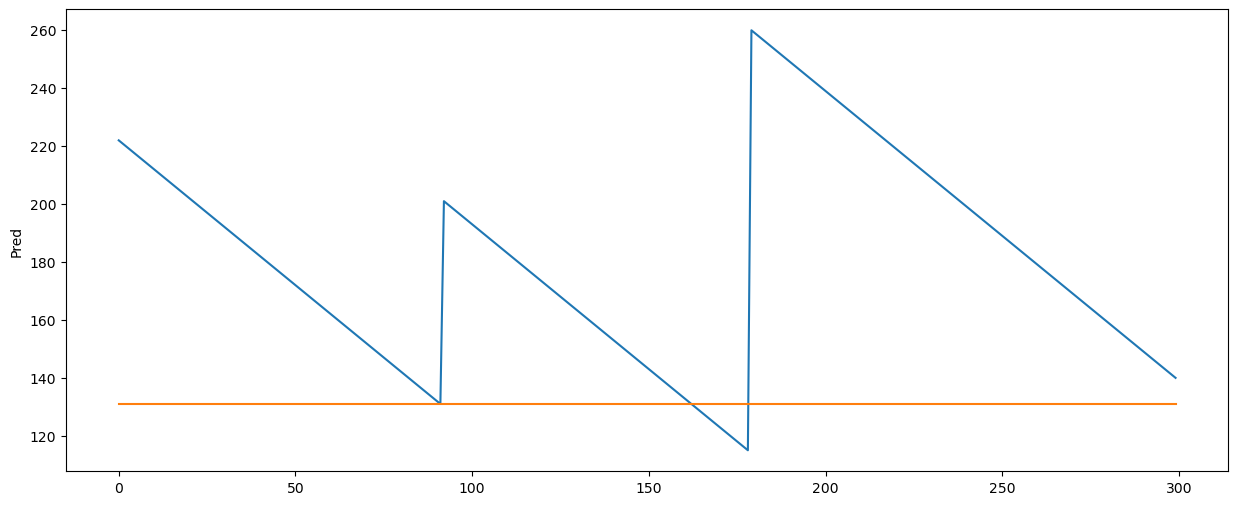

In [35]:
ini = 0
final = 300
plt.figure(figsize=(15, 6))
sns.lineplot(true_y.iloc[ini:final])
sns.lineplot(predicted.iloc[ini:final])
plt.show()

In [36]:
df_train_drop10 = itrain.iloc[:0]
for i in range(1,699):
    drop10 = itrain[itrain['unit_abs']==i][10:]
    df_train_drop10.append(drop10)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:3802 in get_loc              │
│                                                                                                  │
│   3799 │   │   │   │   )                                                                         │
│   3800 │   │   │   casted_key = self._maybe_cast_indexer(key)                                    │
│   3801 │   │   │   try:                                                                          │
│ ❱ 3802 │   │   │   │   return self._engine.get_loc(casted_key)                                   │
│   3803 │   │   │   except KeyError as err:                                                       │
│   3804 │   │   │   │   raise KeyError(key) from err                                              │
│   3805 │   │   │   except TypeError:                                                             │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:138                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:165                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5745                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5753                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'unit_abs'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 df_train_drop10 = itrain.iloc[:0]                                                            │
│   2 for i in range(1,699):                                                                       │
│ ❱ 3 │   drop10 = itrain[itrain['unit_abs']==i][10:]                                              │
│   4 │   df_train_drop10.append(drop10)                                                           │
│   5                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas/core/frame.py:3807 in __getitem__                 │
│                                                                                                  │
│    3804 │   │   if is_single_key:                                                                │
│    3805 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3806 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3807 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3808 │   │   │   if is_integer(indexer):                                                      │
│    3809 │   │   │   │   indexer = [indexer]                                                      │
│    3810 │   │   else:                                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/pandas/core/indexes/base.py:

In [ ]:
df_test_drop10 = itrain.iloc[:0]
for i in range(1,699):
    drop10 = itrain[itrain['unit_abs']==i][10:]
    df_train_drop10.append(drop10)